In [1]:
#imports
import h5py
import scipy.io as io
from PIL import Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import tqdm
import scipy
import scipy.io as io 
from keras import backend as K
from tensorflow import expand_dims
import cv2

from keras.models import Model, Sequential
from keras.layers import Conv2D, Dense, Input, Flatten, MaxPool2D, BatchNormalization, Activation, UpSampling2D
from keras import optimizers
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.initializers import RandomNormal 
from tensorflow.keras.layers import MaxPooling2D
from keras.optimizers import SGD

/tmp/ipykernel_9669/3179167254.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
2022-11-22 18:50:50.111740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 18:50:50.826252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 18:50:50.826325: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 18:50:50.942792: E tensorflow/st

In [2]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

#Creating file path

In [3]:
root='/home/tithi/code/RakshitTithi/ICYO/'

In [4]:
part_A_train=os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data','images')
part_A_test = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/test_data','images')
part_B_train = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_B/train_data','images')
part_B_test = os.path.join(root,'raw_data/Shaghaitech_dataset/ShanghaiTech/part_B/test_data','images')
path_sets = [part_A_train,part_A_test]

In [5]:
len(part_A_train)

101

#create a list of absolute path of jpg file

In [6]:
img_paths=[]
for path in path_sets:
    for img_path in sorted(glob.glob(os.path.join(path,'*.jpg'))):
        img_paths.append(img_path)
        

#creating density map

In [7]:
from tqdm import tqdm

i = 0
# for img_path in tqdm(img_paths):
        
    
# Load sparse matrix
mat = io.loadmat(img_paths[0].replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))

#Read image
img= plt.imread(img_paths[0])

# Create a zero matrix of image size
k = np.zeros((img.shape[0],img.shape[1]))

gt = mat["image_info"][0,0][0,0][0]

#Generate hot encoded matrix of sparse matrix
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1

# generate density map
k = gaussian_filter_density(k)

# File path to save density map
file_path = img_path.replace('.jpg','.h5').replace('images','ground-truth')


with h5py.File(file_path, 'w') as hf:
        hf['density'] = k
    


(768, 1024)
generate density...


/tmp/ipykernel_9669/4212836471.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.


In [8]:
file_path = img_paths[0].replace('.jpg','.h5').replace('images','ground-truth') 
print(file_path)

/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/ground-truth/IMG_1.h5


Sum =  1543.841


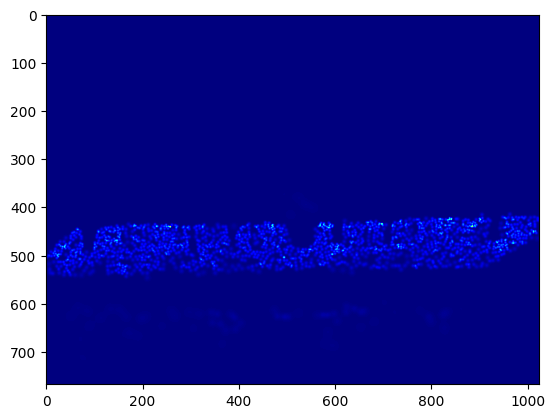

In [9]:
#Sample Ground Truth
gt_file = h5py.File(file_path,'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
Sum=np.sum(groundtruth)
print("Sum = " ,Sum)

/home/tithi/code/RakshitTithi/ICYO/raw_data/Shaghaitech_dataset/ShanghaiTech/part_A/train_data/images/IMG_1.jpg


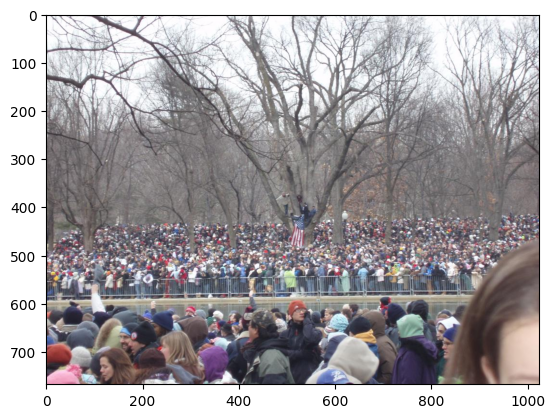

In [10]:
img = Image.open(file_path.replace('.h5','.jpg').replace('ground-truth','images'))
plt.imshow(img)
print(file_path.replace('.h5','.jpg').replace('ground-truth','images'))

In [11]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [12]:
rows = None
cols = None
            
                     
batch_norm = 0
kernel = (3, 3)
init = RandomNormal(stddev=0.01)
model = Sequential() 



model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=2))
model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=2))
model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=2))            
model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
model.add(BatchNormalization())


#Conv2D
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        

sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])


# vgg_16 = VGG16(weights='imagenet', include_top=False) 

# vgg_16(model)

# model.summary()
# model.fit(groundtruth.reshape(768,1024,1), np.array(gt.flatten))
# model.fit(img,groundtruth)

2022-11-22 18:51:54.439446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tithi/.pyenv/versions/3.8.12/envs/ICYO/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-22 18:51:54.440481: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 18:51:54.440546: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-FLJOLQ6E): /proc/driver/nvidia/version does not exist
2022-11-22 18:51:54.445390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

In [13]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)
    
    
    
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    img = np.expand_dims(img,axis  = 2)
    
    #print(img.shape)
    
    return img
    
    
    
def preprocess_input(image,target):
    #crop image
    #crop target
    #resize target
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    
    
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)

    return(img,target_aug)
    
   

In [14]:
#Image data generator 
def image_generator(files, batch_size = 64):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path )
        output = get_output(input_path[0].replace('.jpg','.h5').replace('images','ground-truth') )
            
       
        batch_input += [inputt]
        batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [15]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [16]:
def init_weights_vgg(model):
    #vgg =  VGG16(weights='imagenet', include_top=False)
    
    json_file = open('models/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/VGG_16.h5")
    
    vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)

In [17]:
train_gen = image_generator(img_paths[:1],1)

In [ ]:
model.fit(train_gen,epochs=1,steps_per_epoch= 5 , verbose=1)

2022-11-22 18:52:05.225045: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 201326592 exceeds 10% of free system memory.
2022-11-22 18:52:05.858268: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 201326592 exceeds 10% of free system memory.
2022-11-22 18:52:06.323869: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 201326592 exceeds 10% of free system memory.
2022-11-22 18:52:07.975355: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 201326592 exceeds 10% of free system memory.


In [ ]:
img_paths[0]

In [ ]:
img_= plt.imread(img_paths[0])